In [2]:
import os, math, random, itertools, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageEnhance
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

plt.rcParams['figure.dpi'] = 140
SEED = 42
random.seed(SEED); np.random.seed(SEED)


In [ ]:
DATA_DIR   = "/home/student10/Plant_Disease_Classification/dataset" 
ROOT       = "/home/student10/Plant_Disease_Classification/leaf_preprocessed"                         
IM224_DIR  = f"{ROOT}/images_224"                                     
AUG_DIR    = f"{ROOT}/preprocessed_dataset"                          
SPLIT_DIR  = f"{ROOT}/splitted_dataset"                               
OUT_DIR    = f"{ROOT}/results"                                      

for d in [ROOT, IM224_DIR, AUG_DIR, SPLIT_DIR, OUT_DIR]:
    os.makedirs(d, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("IM224_DIR:", IM224_DIR)
print("AUG_DIR:", AUG_DIR)
print("SPLIT_DIR:", SPLIT_DIR)
print("OUT_DIR:", OUT_DIR)


DATA_DIR: /home/student10/Plant_Disease_Classification/dataset
IM224_DIR: /home/student10/Plant_Disease_Classification/leaf_preprocessed/images_224
AUG_DIR: /home/student10/Plant_Disease_Classification/leaf_preprocessed/preprocessed_dataset
SPLIT_DIR: /home/student10/Plant_Disease_Classification/leaf_preprocessed/splitted_dataset
OUT_DIR: /home/student10/Plant_Disease_Classification/leaf_preprocessed/results


In [ ]:
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import re, uuid

def center_crop_exact_224(img: Image.Image) -> Image.Image:
    w, h = img.size
    if w < 224 or h < 224:
        img = img.resize((max(224, w), max(224, h)), Image.BILINEAR)
        w, h = img.size
    left = (w - 224) // 2
    top  = (h - 224) // 2
    return img.crop((left, top, left + 224, top + 224))

def sanitize_stem(stem: str, maxlen: int = 150) -> str:
    stem = stem.strip()
    stem = re.sub(r'[^A-Za-z0-9._-]+', '_', stem)
    if not re.sub(r'[^A-Za-z0-9]+', '', stem):
        stem = "img"
    return stem[:maxlen]

def export_224_all(src_root, dst_root):
    src_root, dst_root = Path(src_root), Path(dst_root)
    classes = sorted([p.name for p in src_root.iterdir() if p.is_dir()])
    assert len(classes), "Không thấy class folder trong DATA_DIR."
    for c in classes:
        (dst_root/c).mkdir(parents=True, exist_ok=True)

    exts = {".jpg",".jpeg",".png",".bmp",".webp"}
    for c in classes:
        files = sorted([p for p in (src_root/c).iterdir() if p.suffix.lower() in exts])
        for p in tqdm(files, desc=f"[CROP 224] {c:>25}"):
            try:
                im = Image.open(p).convert("RGB")
            except Exception as e:
                print(f"[SKIP open] {p.name} -> {e}")
                continue

            im224 = center_crop_exact_224(im)

            safe = sanitize_stem(p.stem)
            out_path = dst_root/c/(safe + ".png")

            if out_path.exists():
                continue

            try:
                im224.save(out_path, "PNG", optimize=True)
            except Exception as e:
                alt = dst_root/c/(f"{safe}_{uuid.uuid4().hex[:8]}.png")
                try:
                    im224.save(alt, "PNG", optimize=True)
                except Exception as e2:
                    print(f"[SKIP save] {p.name} -> {e2}")
                    continue
    print("✅ Done: center-crop -> 224×224 tại", dst_root)

export_224_all(DATA_DIR, IM224_DIR)


[CROP 224]            Tomato_healthy: 100%|██████████| 1591/1591 [00:23<00:00, 67.65it/s]

✅ Done: center-crop -> 224×224 tại /home/student10/Plant_Disease_Classification/leaf_preprocessed/images_224


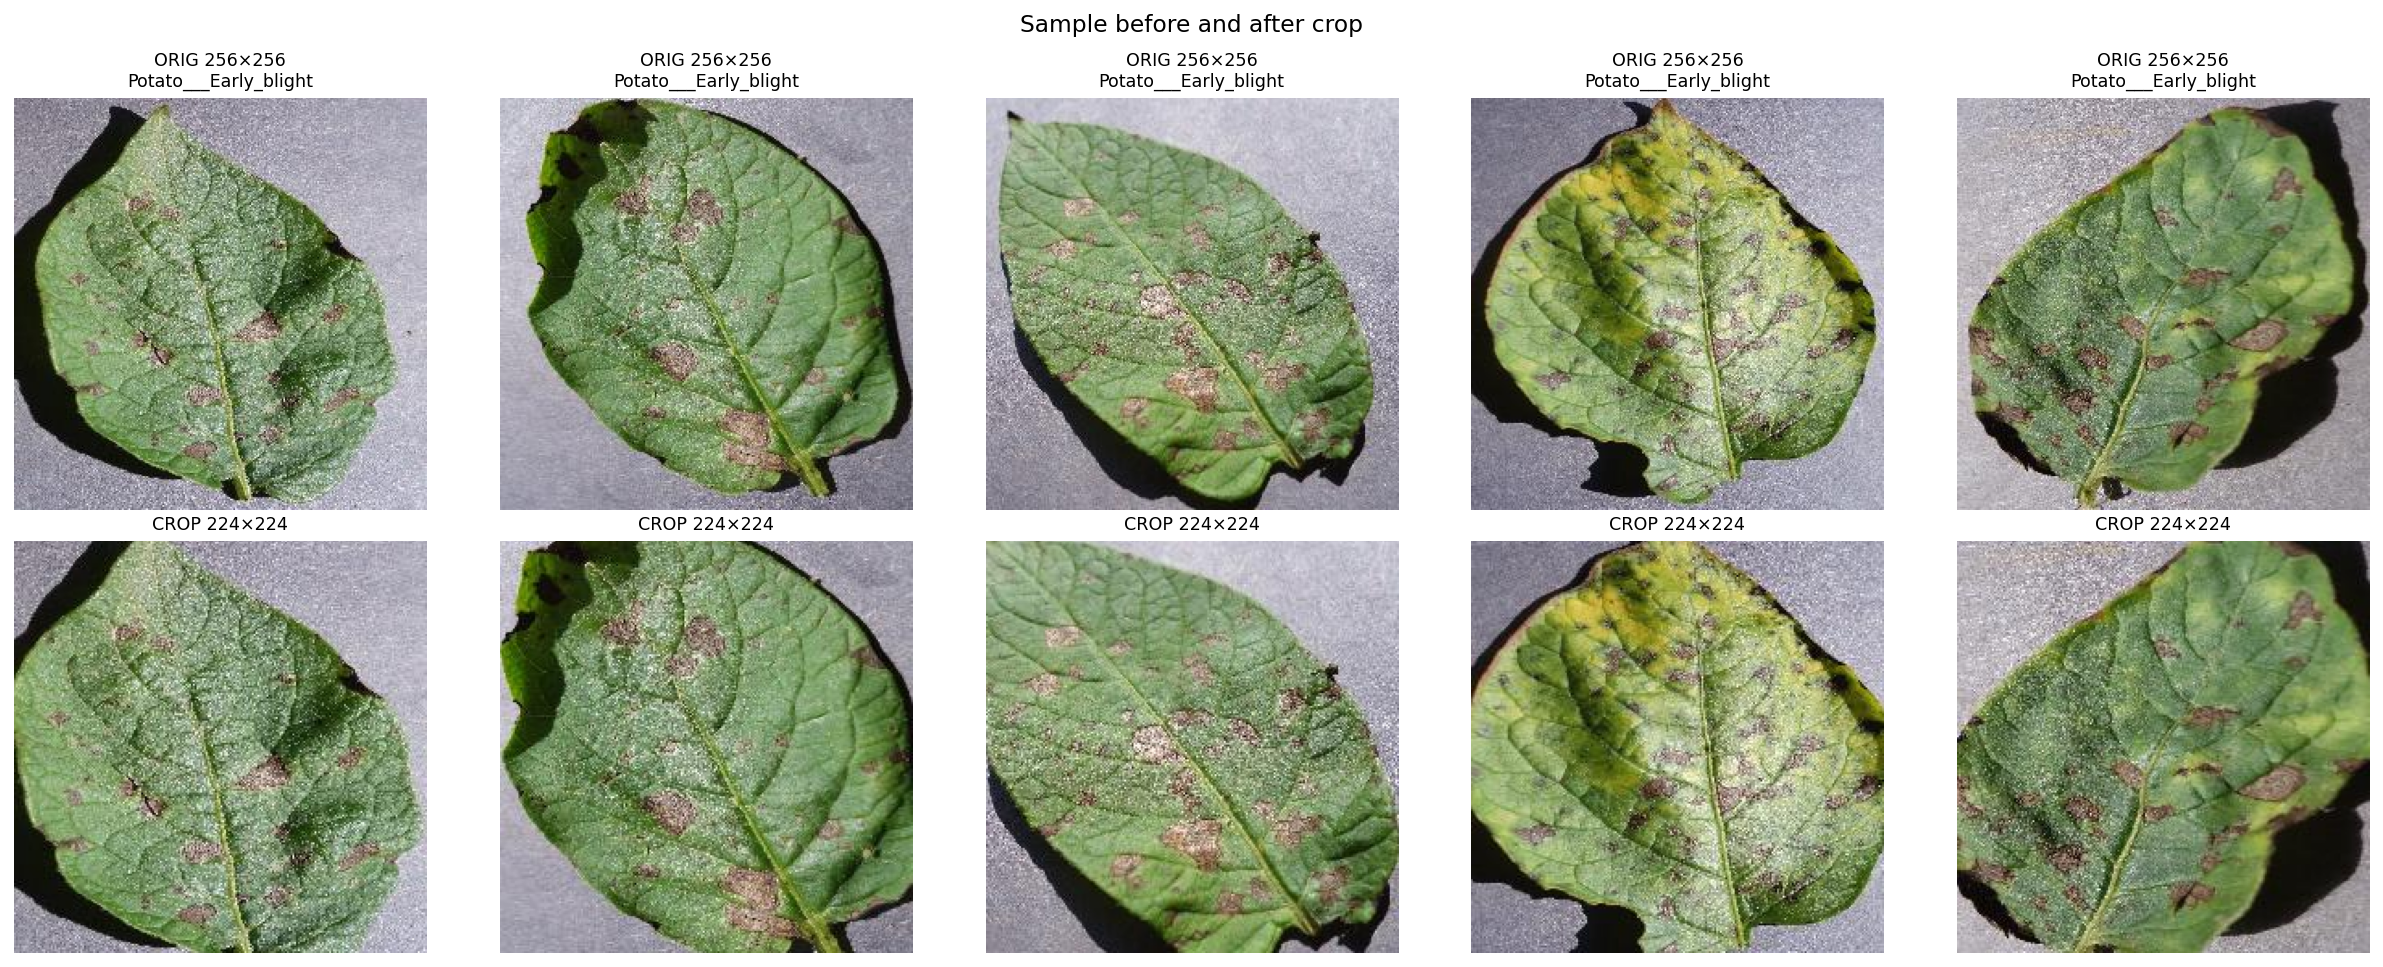

In [ ]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def show_orig_vs_crop(DATA_DIR, IM224_DIR, sanitize_func, max_pairs=10):
    DATA_DIR, IM224_DIR = Path(DATA_DIR), Path(IM224_DIR)
    pairs = []
    classes = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
    for cls in classes:
        orig_dir = DATA_DIR/cls
        crop_dir = IM224_DIR/cls
        if not crop_dir.exists():
            continue
        files = [p for p in orig_dir.iterdir() if p.suffix.lower() in EXTS]
        for p in files:
            safe = sanitize_func(p.stem)  
            p_crop = crop_dir/(safe + ".png")
            if p_crop.exists():
                pairs.append((p, p_crop))
                if len(pairs) >= max_pairs:
                    break
        if len(pairs) >= max_pairs:
            break

    assert pairs, "Không tìm thấy cặp ảnh để hiển thị. Kiểm tra DATA_DIR/IM224_DIR và hàm sanitize_stem."

    cols = min(5, len(pairs))
    rows = 2
    plt.figure(figsize=(cols*3.5, rows*3.5))
    for i, (p_orig, p_crop) in enumerate(pairs[:cols]):
        im_o = Image.open(p_orig).convert("RGB")
        im_c = Image.open(p_crop).convert("RGB")

        ax1 = plt.subplot(rows, cols, i+1)
        ax1.imshow(im_o); ax1.axis('off')
        ax1.set_title(f"ORIG {im_o.size[0]}×{im_o.size[1]}\n{p_orig.parent.name}", fontsize=9)

        ax2 = plt.subplot(rows, cols, cols + i + 1)
        ax2.imshow(im_c); ax2.axis('off')
        ax2.set_title("CROP 224×224", fontsize=9)

    plt.suptitle("Sample before and after crop", y=0.98)
    plt.tight_layout()
    plt.show()

show_orig_vs_crop(DATA_DIR, IM224_DIR, sanitize_stem, max_pairs=10)


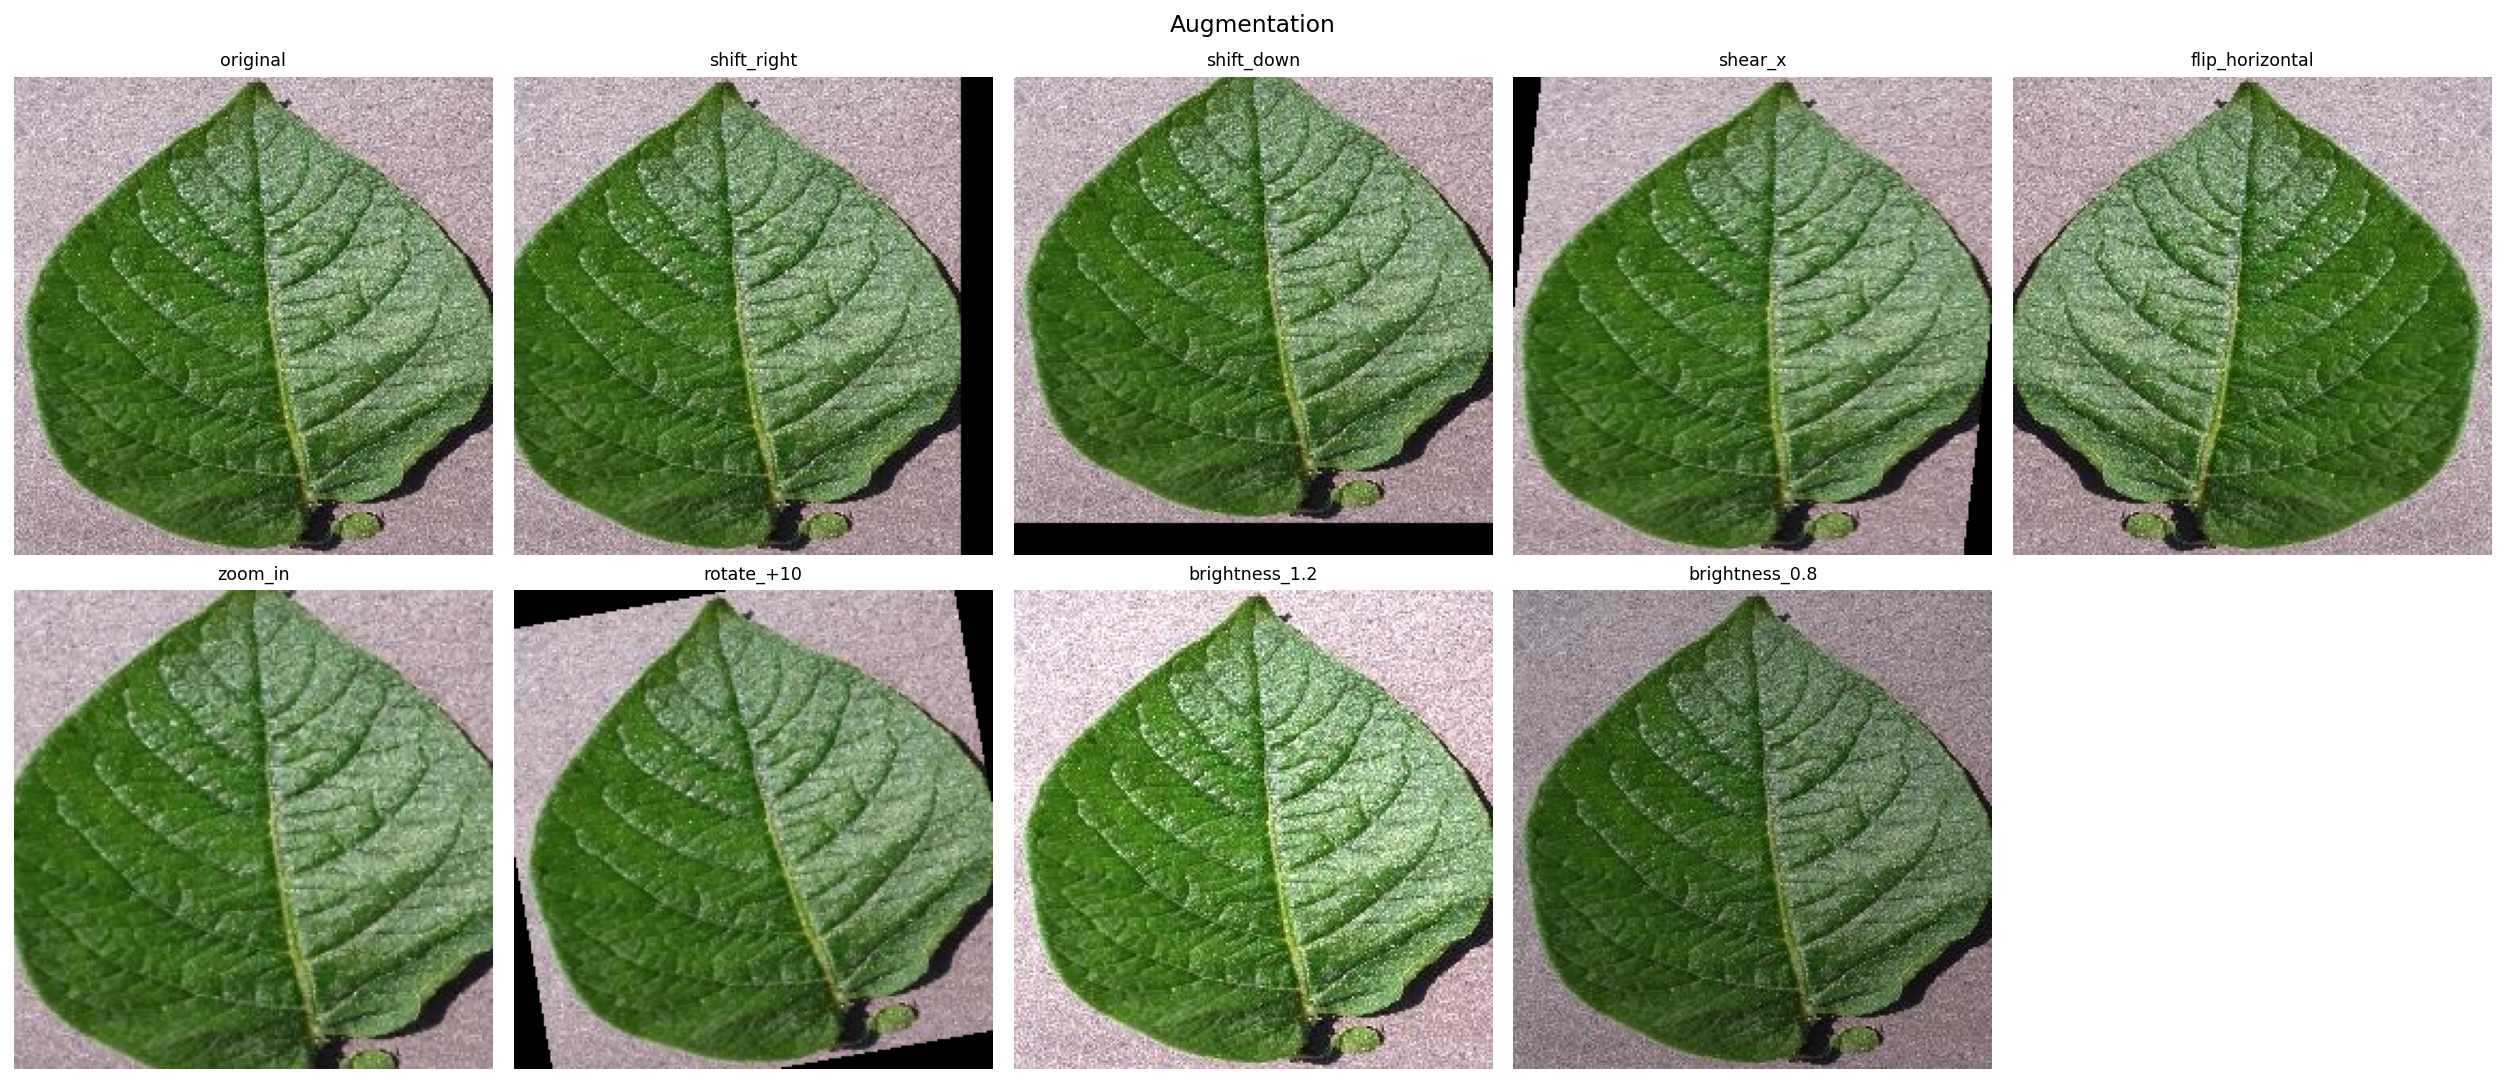

Ảnh demo từng bước đã lưu tại: /home/student10/Plant_Disease_Classification/leaf_preprocessed/results/augmentation_demo


[AUGMENT]            Tomato_healthy: 100%|██████████| 1591/1591 [03:42<00:00,  7.15it/s]


✅ Done: augmentation full dataset tại /home/student10/Plant_Disease_Classification/leaf_preprocessed/preprocessed_dataset
    Potato___Early_blight: 9000
     Potato___Late_blight: 9000
         Potato___healthy: 1368
      Tomato_Early_blight: 9000
       Tomato_Late_blight: 17181
           Tomato_healthy: 14319
Tổng: 59868


In [ ]:
def shift(img, dx=0, dy=0):
    return img.transform(img.size, Image.AFFINE, (1,0,dx, 0,1,dy), resample=Image.BILINEAR, fillcolor=(0,0,0))

def shear_x(img, sh=0.1):
    w,h = img.size
    return img.transform(img.size, Image.AFFINE, (1, sh, -sh*h/2, 0,1,0), resample=Image.BILINEAR, fillcolor=(0,0,0))

def horiz_flip(img):
    return img.transpose(Image.FLIP_LEFT_RIGHT)

def zoom_in(img, factor=1.1):
    w,h = img.size
    new_w, new_h = int(w*factor), int(h*factor)
    im = img.resize((new_w,new_h), Image.BILINEAR)
    left = (new_w - w)//2; top=(new_h - h)//2
    return im.crop((left, top, left+w, top+h))

def rotate_deg(img, deg=10):
    return img.rotate(deg, resample=Image.BILINEAR, expand=False, fillcolor=(0,0,0))

def change_brightness(img, factor=1.2):
    return ImageEnhance.Brightness(img).enhance(factor)

DEMO_DIR = Path(OUT_DIR)/"augmentation_demo"; DEMO_DIR.mkdir(parents=True, exist_ok=True)

one_img_path = next(Path(IM224_DIR).rglob("*.png"))
im0 = Image.open(one_img_path).convert("RGB")

demo_steps = [
    ("original",        im0),
    ("shift_right",     shift(im0, dx=15, dy=0)),
    ("shift_down",      shift(im0, dx=0, dy=15)),
    ("shear_x",         shear_x(im0, sh=0.12)),
    ("flip_horizontal", horiz_flip(im0)),
    ("zoom_in",         zoom_in(im0, factor=1.12)),
    ("rotate_+10",      rotate_deg(im0, 10)),
    ("brightness_1.2",  change_brightness(im0, 1.2)),
    ("brightness_0.8",  change_brightness(im0, 0.8)),
]

plt.figure(figsize=(18,8))
for i, (name, im) in enumerate(demo_steps):
    plt.subplot(2, len(demo_steps)//2 + len(demo_steps)%2, i+1)
    plt.imshow(im); plt.title(name, fontsize=9); plt.axis('off')
    im.save(DEMO_DIR / f"demo_{i:02d}_{name}.png", "PNG", optimize=True)
plt.suptitle("Augmentation"); plt.tight_layout(); plt.show()
print("Ảnh demo từng bước đã lưu tại:", DEMO_DIR)

AUG_FUNCS = [
    ("sr", lambda im: shift(im, dx=12, dy=0)),
    ("sd", lambda im: shift(im, dx=0, dy=12)),
    ("sh", lambda im: shear_x(im, sh=0.10)),
    ("hf", lambda im: horiz_flip(im)),
    ("zm", lambda im: zoom_in(im, factor=1.10)),
    ("rt", lambda im: rotate_deg(im, deg=10)),
    ("br", lambda im: change_brightness(im, 1.15)),
    ("dk", lambda im: change_brightness(im, 0.85)),
]

def augment_full_dataset(src_224_dir, dst_aug_dir):
    src_224_dir, dst_aug_dir = Path(src_224_dir), Path(dst_aug_dir)
    classes = sorted([p.name for p in src_224_dir.iterdir() if p.is_dir()])
    exts = {".png",".jpg",".jpeg",".bmp",".webp"}

    for c in classes:
        (dst_aug_dir/c).mkdir(parents=True, exist_ok=True)

    for c in classes:
        files = sorted([p for p in (src_224_dir/c).iterdir() if p.suffix.lower() in exts])
        for p in tqdm(files, desc=f"[AUGMENT] {c:>25}"):
            im = Image.open(p).convert("RGB")
            base = p.stem
            im.save(dst_aug_dir/c/f"{base}_orig.png", "PNG", optimize=True)

            # Lưu từng biến thể
            for tag, fn in AUG_FUNCS:
                out = fn(im)
                out.save(dst_aug_dir/c/f"{base}_{tag}.png", "PNG", optimize=True)
    print("✅ Done: augmentation full dataset tại", dst_aug_dir)

augment_full_dataset(IM224_DIR, AUG_DIR)

def count_images(root):
    root = Path(root)
    classes = sorted([p.name for p in root.iterdir() if p.is_dir()])
    total = 0
    for c in classes:
        n = len(list((root/c).glob("*.png")))
        total += n
        print(f"{c:>25}: {n}")
    print("Tổng:", total)

count_images(AUG_DIR)


In [ ]:
import shutil, concurrent.futures as cf
from pathlib import Path
from tqdm import tqdm
import random

def split_copy_dataset_fast(src_dir, dst_dir,
                            p_train=0.70, p_val=0.15, p_test=0.15,
                            workers=8, skip_existing=True, seed=42):
    """
    - Copy song song bằng ThreadPoolExecutor
    - shutil.copy2 (nhanh, nhẹ RAM)
    - skip_existing=True: resume được
    """
    assert abs(p_train + p_val + p_test - 1.0) < 1e-6
    src_dir, dst_dir = Path(src_dir), Path(dst_dir)
    rng = random.Random(seed)
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".webp"}

    classes = [p.name for p in src_dir.iterdir() if p.is_dir()]
    classes.sort()

    for sp in ["train", "val", "test"]:
        for c in classes:
            (dst_dir/sp/c).mkdir(parents=True, exist_ok=True)

    jobs = []
    for c in classes:
        files = sorted([p for p in (src_dir/c).iterdir() if p.suffix.lower() in exts])
        rng.shuffle(files)
        n = len(files)
        n_tr = int(n * p_train)
        n_va = int(n * p_val)
        parts = {
            "train": files[:n_tr],
            "val":   files[n_tr:n_tr+n_va],
            "test":  files[n_tr+n_va:]
        }
        for sp, lst in parts.items():
            out_dir = dst_dir/sp/c
            for p in lst:
                dst_path = out_dir/p.name
                if skip_existing and dst_path.exists():
                    continue
                jobs.append((p, dst_path))

    print(f"Tổng số file cần copy: {len(jobs)}")

    def _copy_one(job):
        src, dst = job
        try:
            dst.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src, dst)  
            return True
        except Exception as e:
            return e

    ok, err = 0, 0
    with cf.ThreadPoolExecutor(max_workers=workers) as ex:
        for res in tqdm(ex.map(_copy_one, jobs), total=len(jobs), desc="[SPLIT] copying"):
            if res is True:
                ok += 1
            else:
                err += 1

    print(f"✅ Done split tại {dst_dir} | Copied: {ok} | Errors: {err}")

split_copy_dataset_fast(AUG_DIR, SPLIT_DIR, workers=8, skip_existing=True, seed=SEED)

def count_images(root):
    root = Path(root)
    classes = sorted([p.name for p in root.iterdir() if p.is_dir()])
    total = 0
    for c in classes:
        n = len(list((root/c).glob("*.png"))) + len(list((root/c).glob("*.jpg"))) \
            + len(list((root/c).glob("*.jpeg"))) + len(list((root/c).glob("*.bmp"))) \
            + len(list((root/c).glob("*.webp")))
        total += n
        print(f"{c:>25}: {n}")
    print("Tổng:", total)

def count_split(root):
    root = Path(root)
    for sp in ["train","val","test"]:
        print(f"\n[{sp.upper()}]")
        if (root/sp).exists():
            count_images(root/sp)
        else:
            print("— không thấy thư mục —")

count_split(SPLIT_DIR)


Tổng số file cần copy: 59868


[SPLIT] copying: 100%|██████████| 59868/59868 [00:27<00:00, 2187.24it/s]


✅ Done split tại /home/student10/Plant_Disease_Classification/leaf_preprocessed/splitted_dataset | Copied: 59868 | Errors: 0

[TRAIN]
    Potato___Early_blight: 6300
     Potato___Late_blight: 6300
         Potato___healthy: 957
      Tomato_Early_blight: 6300
       Tomato_Late_blight: 12026
           Tomato_healthy: 10023
Tổng: 41906

[VAL]
    Potato___Early_blight: 1350
     Potato___Late_blight: 1350
         Potato___healthy: 205
      Tomato_Early_blight: 1350
       Tomato_Late_blight: 2577
           Tomato_healthy: 2147
Tổng: 8979

[TEST]
    Potato___Early_blight: 1350
     Potato___Late_blight: 1350
         Potato___healthy: 206
      Tomato_Early_blight: 1350
       Tomato_Late_blight: 2578
           Tomato_healthy: 2149
Tổng: 8983
